In [1]:
# Import dataset

import pandas as pd
import warnings
import sys  

PROJECT_FOLDER = '/home/ricardo/coding/data-science/projects/predict_value_change_from_fm_data/'

sys.path.insert(0, PROJECT_FOLDER)
warnings.filterwarnings('ignore')

fm20_df = pd.read_csv(PROJECT_FOLDER + "datasets/datafm20.csv")

<AxesSubplot:>

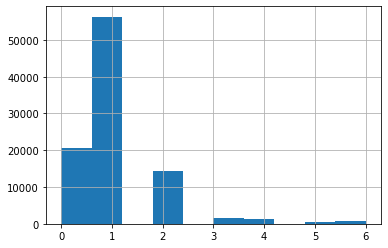

In [38]:
# Prepare df for stratify

import numpy as np

players_df = fm20_df.query('Age <= 27 & `Best Pos` != "GK"')
players_df["Value_cat"] = pd.cut(players_df["Value"], bins=[-1, 0, 100000, 1000000, 2000000, 5000000, 10000000, np.inf], labels=[0, 1, 2, 3, 4, 5, 6])
players_df["Value_cat"].hist()


In [39]:
# Create test set

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(players_df, players_df['Value'], test_size=0.2, random_state=42, stratify=players_df['Value_cat'])

In [40]:
# Drop stratify category
for set_ in (x_train, x_test):
    set_.drop("Value_cat", axis=1, inplace=True)

In [ ]:
# Select features of the dataset we will work with

from utils import PLAYER_ATTR

features = PLAYER_ATTR + ['Age', 'Preferred Foot', 'Best Pos', 'Nation']
players_df = fm20_df[features]

In [ ]:
# After EDA, some additional features may be useful

from utils import apply_mean_attribute_list

apply_mean_attribute_list(players_df, 'PHY', ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat'])
apply_mean_attribute_list(players_df, 'MEN', ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg'])
apply_mean_attribute_list(players_df, 'M+P', ['MEN', 'PHY'])

In [79]:
# Revert to clean training set

players = x_train.drop('Value', axis=1)
players_labels = x_train['Value'].copy()

In [85]:
# Data cleaning - Value

value_bins = [-1, 0, 100000, 1000000, 2000000, 5000000, 10000000, np.inf]

players_labels = pd.cut(players_labels, bins=value_bins, labels=range(len(value_bins) - 1))

In [48]:
# Data cleaning - Preferred foot

from sklearn.preprocessing import OneHotEncoder
foot_encoder = OneHotEncoder()
players_foot = foot_encoder.fit_transform(players['Preferred Foot'].values.reshape(-1, 1))
players[foot_encoder.categories_[0]] = players_foot.toarray()

In [50]:
# Data cleaning - Best position

from sklearn.preprocessing import OneHotEncoder
pos_encoder = OneHotEncoder()
players_pos = pos_encoder.fit_transform(players['Best Pos'].values.reshape(-1, 1))
players[pos_encoder.categories_[0]] = players_pos.toarray()

In [54]:
# Data cleaning - Nation

fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
players['Nation_rank'] = players['Nation'].map(nation_encoder.set_index('country_abrv')['rank'])
players['Nation_rank'] = players['Nation_rank'].fillna(nation_encoder['rank'].max() + 1)

In [75]:
# Custom Nation transformer

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        fifa_wr = pd.read_csv(PROJECT_FOLDER + "datasets/fifa_ranking-2021-05-27.csv")
        nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        max_rank = nation_encoder['rank'].max() + 1
        X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        X.drop('Nation', axis=1, inplace=True)
        return X

In [76]:
# Using transformation pipelines

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from utils import PLAYER_ATTR

players = x_train.drop('Value', axis=1)

num_attribs = PLAYER_ATTR + ['Age']
cat_attribs = ['Preferred Foot', 'Best Pos']
nat_attrib = ['Nation']

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    ("nat", NationToRank(), nat_attrib)
])

players_prepared = full_pipeline.fit_transform(players)

In [88]:
# Select and train model
## RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

value_predictor = RandomForestClassifier(max_depth=64, n_estimators = 50, random_state = 42)
value_predictor.fit(players_prepared, players_labels)

RandomForestClassifier(max_depth=64, n_estimators=50, random_state=42)

In [90]:
# Error analysis

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

value_predictions = cross_val_predict(value_predictor, players_prepared, players_labels, cv=5)

TypeError: confusion_matrix() missing 1 required positional argument: 'y_pred'

<AxesSubplot:>

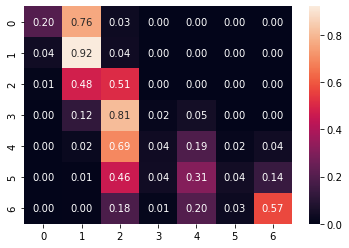

In [97]:
import seaborn as sns

conf_mx = confusion_matrix(players_labels, value_predictions)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

In [102]:
evaluate_outliers = players[['Name', 'Division', 'Based']]
evaluate_outliers['Value'] = players_df['Value']
evaluate_outliers['Val_dif'] = value_predictions - players_labels.astype(np.int8)
